# eBOSS Quasar Luminosity Function

In this example, we attempt to reproduce the pure luminosity evolution model for quasar luminosity function as in Palanque-Delabrouille et al. 2016 ([arXiv:1509.05607](https://arxiv.org/abs/1509.05607)).

In [1]:
from pprint import pformat

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from astropy.cosmology import Planck15
from mpl_toolkits import mplot3d

from conf import PATHEXT
from horizonground.lumfunc_likelihood import LumFuncMeasurements
from horizonground.lumfunc_modeller import LumFuncModeller, quasar_PLE_lumfunc, quasar_hybrid_lumfunc

First we define for the luminosity function parameter ranges under consideration: magniotude $m$, redshift $z$ and lumonisty function value $\Phi(m, z)$.

In [2]:
MAGNITUDE_RANGE = -29.0, -20.6
REDSHIFT_RANGE = 0.25, 3.
DENSITY_RANGE = pow(10, -9.225), pow(10, -4.775)

## eBOSS QSO luminosity function data

We load eBOSS QSO luminosity function data from text files.

In [3]:
measurement_file = PATHEXT/"eBOSS_QSO_LF_measurements.txt"
uncertainty_file = PATHEXT/"eBOSS_QSO_LF_uncertainties.txt"

luminosity_function_data = LumFuncMeasurements(measurement_file, uncertainty_file, base10_log=False)

## Quasar luminosity function model

We employ *LumFuncModeller* to model the quasar luminosity function with the best-fit parameters loaded from a text file, and set relevant model options.

In [4]:
PLE_model = LumFuncModeller.from_parameter_file(
    parameter_file=PATHEXT/"eBOSS_QSO_LF_PLE_model_fits.txt",
    model_lumfunc=quasar_PLE_lumfunc,
    luminosity_variable='magnitude',
    threshold_value=-21.80,
    cosmology=Planck15
)

PLE_LF = PLE_model.luminosity_function

In [5]:
hybrid_model = LumFuncModeller.from_parameter_file(
    parameter_file=PATHEXT/"eBOSS_QSO_LF_PLE+LEDE_model_fits.txt",
    model_lumfunc=quasar_hybrid_lumfunc,
    luminosity_variable='magnitude',
    threshold_value=-21.80,
    cosmology=Planck15
)

hybrid_LF = hybrid_model.luminosity_function

The luminosity function can be visualised as a surface over $(m, z)$ coordinates.

Text(0.5, 0, '$\\Phi(m,z)$ [$\\mathrm{Mpc}^{-3} \\mathrm{mag}^{-1}$]')

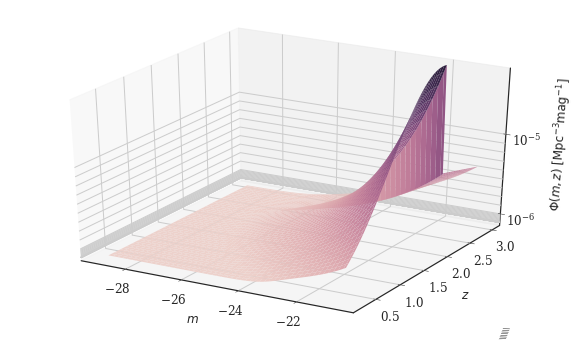

In [6]:
NUM_MESH = 100

magnitudes = np.linspace(*MAGNITUDE_RANGE, num=NUM_MESH, endpoint=False)
redshifts = np.linspace(*REDSHIFT_RANGE, num=NUM_MESH, endpoint=False)

m_grid, z_grid = np.meshgrid(magnitudes, redshifts)
Phi_grid = PLE_LF(m_grid, z_grid)

fig = plt.figure("Luminosity function surface", figsize=(10, 6))
ax = plt.axes(projection='3d')

ax.plot_surface(m_grid, z_grid, Phi_grid, cmap=sns.cubehelix_palette(as_cmap=True), edgecolor='none')

ax.set_xlabel(r"$m$", labelpad=10)
ax.set_ylabel(r"$z$", labelpad=10)

ax.set_zscale('log')
ax.set_zlim(*DENSITY_RANGE)
ax.set_zticks([pow(10, -5), pow(10, -6)])
ax.set_zlabel(r"$\Phi(m,z)$ [$\mathrm{Mpc}^{-3} \mathrm{mag}^{-1}$]", labelpad=10)

Text(0.5, 0, '$\\Phi(m,z)$ [$\\mathrm{Mpc}^{-3} \\mathrm{mag}^{-1}$]')

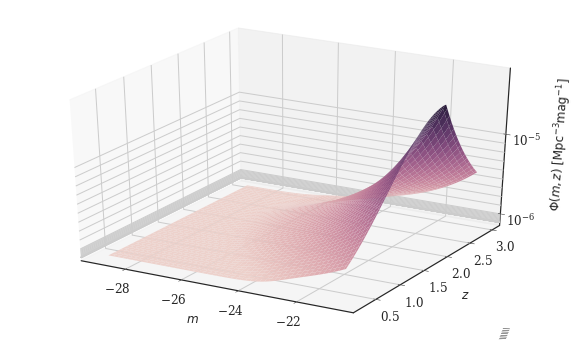

In [7]:
NUM_MESH = 100

magnitudes = np.linspace(*MAGNITUDE_RANGE, num=NUM_MESH, endpoint=False)
redshifts = np.linspace(*REDSHIFT_RANGE, num=NUM_MESH, endpoint=False)

m_grid, z_grid = np.meshgrid(magnitudes, redshifts)
Phi_grid = hybrid_LF(m_grid, z_grid)

fig = plt.figure("Luminosity function surface", figsize=(10, 6))
ax = plt.axes(projection='3d')

ax.plot_surface(m_grid, z_grid, Phi_grid, cmap=sns.cubehelix_palette(as_cmap=True), edgecolor='none')

ax.set_xlabel(r"$m$", labelpad=10)
ax.set_ylabel(r"$z$", labelpad=10)

ax.set_zscale('log')
ax.set_zlim(*DENSITY_RANGE)
ax.set_zticks([pow(10, -5), pow(10, -6)])
ax.set_zlabel(r"$\Phi(m,z)$ [$\mathrm{Mpc}^{-3} \mathrm{mag}^{-1}$]", labelpad=10)

## eBoss QSO luminosity function results

We now plot the best-fit luminosity model sampled at the following magnitude values. We also plot the measurements and uncertainties in magnitude and redshift bins.

In [8]:
NUM_MAG_INTERVALS = 100

m = np.linspace(*MAGNITUDE_RANGE, num=NUM_MAG_INTERVALS+1)

magnitude_bins = luminosity_function_data.luminosity_bins
redshift_bins = luminosity_function_data.redshift_bins
redshift_labels = luminosity_function_data.redshift_labels

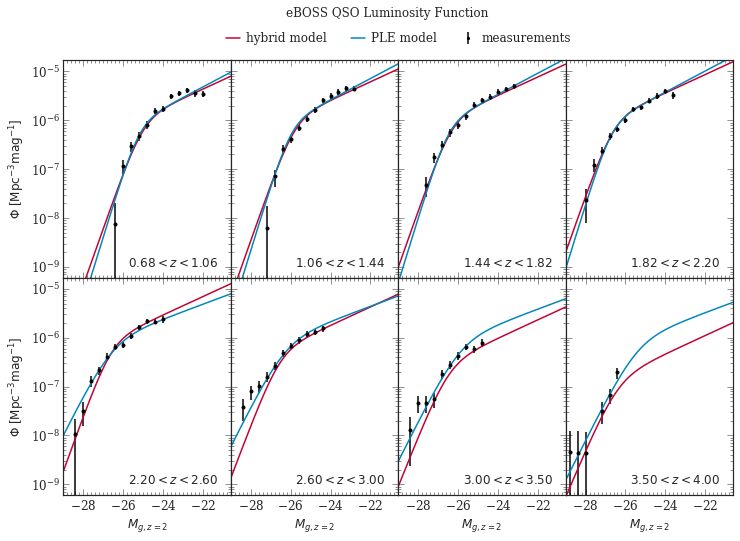

In [9]:
NUM_ROW, NUM_COL = 2, 4
ROW_SPAN, COL_SPAN = 4, 3

fig = plt.figure(figsize=(12, 8))
for bin_idx, z in enumerate(redshift_bins):
    # Set up the canvas grid.
    row_idx, col_idx = bin_idx // NUM_COL, bin_idx % NUM_COL 
    ax = plt.subplot2grid(
        (NUM_ROW * ROW_SPAN, NUM_COL * COL_SPAN), (row_idx * ROW_SPAN, col_idx * COL_SPAN), 
        rowspan=ROW_SPAN, colspan=COL_SPAN
    )
        
    # Plot with different options depending on the subplot.
    if bin_idx == 0:
        plt.errorbar(
            magnitude_bins, *luminosity_function_data[bin_idx],
            fmt='o', markersize=4., capsize=0., label='measurements'
        )
        plt.plot(m, hybrid_LF(m, z), label='hybrid model')
        plt.plot(m, PLE_LF(m, z), label='PLE model')
    else:
        plt.errorbar(
            magnitude_bins, *luminosity_function_data[bin_idx],
            fmt='o', markersize=4., capsize=0.
        )
        plt.plot(m, hybrid_LF(m, z))
        plt.plot(m, PLE_LF(m, z))
        
    # Set axis ticks and labels.
    plt.xscale('linear')
    plt.xlim(*MAGNITUDE_RANGE)
    
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2.))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
    if row_idx + 1 < NUM_ROW:
        plt.tick_params(axis='x', which='both', direction='in', labelbottom=False, labelsize=2)
    else:
        plt.xlabel(r"$M_{g,z=2}$")
        
    plt.yscale('log')    
    plt.ylim(*DENSITY_RANGE)
    
    if col_idx > 0:
        plt.tick_params(axis='y', which='both', direction='in', labelleft=False, labelsize=2)
    else:
        plt.ylabel(r"$\Phi$ [$\mathrm{Mpc}^{-3} \mathrm{mag}^{-1}$]")
    
    plt.title(redshift_labels[bin_idx], loc='right', position=(0.925, 0.025))
    
lines, labels = [], []
for ax in fig.axes:
    ax_line, ax_label = ax.get_legend_handles_labels()
    lines.extend(ax_line)
    labels.extend(ax_label)
     
plt.legend(
    lines, labels, ncol=4, handlelength=1.2, handletextpad=0.5,
    bbox_to_anchor=(-1., 2.1), loc='center'    
)
plt.suptitle("eBOSS QSO Luminosity Function", verticalalignment='bottom', y=0.95)
plt.subplots_adjust(hspace=0, wspace=0)